In [1]:
%matplotlib ipympl
# % matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import netCDF4
import xarray as xr
import pandas as pd
import seaborn as sns
import os
#plt.style.use('seaborn')

from scipy import stats
from scipy.fft import fft, fftfreq, fftshift

#### Data Opening Functions

In [2]:
def data_opening_w_stripe(stripe, d):
    dsf_raw = xr.open_dataset(d,engine = 'netcdf4')  

    # FOR FUV A SWP
    if 'ICON_L1_FUVA_SWP_Center_Times' in dsf_raw.variables.keys():
        dsf = dsf_raw[['ICON_L1_FUVA_SWP_Center_Times','ICON_L1_FUVA_SWP_PROF_'+str(stripe)]]
        # Convert times to something Python and xarray can understand, and reindex the dataset by time 
        t = pd.to_datetime(dsf.ICON_L1_FUVA_SWP_Center_Times.values)
        dsf['time'] = (['Epoch'], t)
        dsf = dsf.swap_dims({'Epoch':'time'})
        dsf = dsf.rename({'Rows':'row'})
        # Rename and drop useless variables
        dsf['I_1356'] = dsf['ICON_L1_FUVA_SWP_PROF_'+str(stripe)]
        dsf = dsf.drop(['ICON_L1_FUVA_SWP_PROF_'+str(stripe),'ICON_L1_FUVA_SWP_Center_Times','Epoch'])
    
    # FOR FUV B LWP
    elif 'ICON_L1_FUVB_LWP_Center_Times' in dsf_raw.variables.keys():
        dsf = dsf_raw[['ICON_L1_FUVB_LWP_Center_Times','ICON_L1_FUVB_LWP_PROF_'+str(stripe)]]
        # Convert times to something Python and xarray can understand, and reindex the dataset by time 
        t = pd.to_datetime(dsf.ICON_L1_FUVB_LWP_Center_Times.values)
        dsf['time'] = (['Epoch'], t)
        dsf = dsf.swap_dims({'Epoch':'time'})
        dsf = dsf.rename({'Rows':'row'})
        #  Rename and drop useless variables
        dsf['N2'] = dsf['ICON_L1_FUVB_LWP_PROF_'+str(stripe)]
        dsf = dsf.drop(['ICON_L1_FUVB_LWP_PROF_'+str(stripe),'ICON_L1_FUVB_LWP_Center_Times','Epoch'])    
      
    return dsf

#### Orbit Separation Functions

In [3]:
def orbits_finder(df):
    from scipy.signal import find_peaks
    data = df.I_1356.mean(dim = 'row')
    data_np = data.to_numpy()
    np.shape(data)

    max_data = max(data_np)
    time_diff = pd.to_timedelta('75 m')
    half_time_diff = pd.to_timedelta('50 m')

    indices = find_peaks(data, height = max_data * (4/6)) 

    indexes = indices[0]
    indexes 

    final_indexes = []

    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 200:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    
    times_np = df.time.to_numpy()
    times_dt = pd.to_datetime(times_np)
    
    all_orbits = []
    for i in final_indexes:
        start_time = times_dt[i] - half_time_diff
        end_time = start_time + time_diff
        df_orbit = df.sel(time=slice(start_time, end_time))
        all_orbits.append(df_orbit)
        
    return all_orbits

In [4]:
def single_orb(orbit_arr,n):
    orb = orbit_arr[n].mean(dim = 'row')
    t = orb.time
    
    if 'I_1356' in orb.variables.keys():
        val = orb.I_1356
    elif 'N2' in orb.variables.keys():
        val = orb.N2
        
    return(t, val)

#### Wavelength Finder

In [5]:
def wavelength_plots(swp_data,day,orbit_num,nsamples):
    
    # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    swp_data['I_1356_filt'] = swp_data['I_1356'] - swp_data['I_1356'].rolling(time=nsamples, center=True).mean() 
    
    #SLICE OUT END FEATURES
    s = len(swp_data["I_1356_filt"])
    lim_val = int(s/6)
    s_lim = int(1.5 * lim_val)

    time_start = swp_data['time'].isel(time=s_lim).values
    time_end =  swp_data['time'].isel(time=lim_val * 5).values
    swp_data = swp_data.sel(time=slice(time_start, time_end))
    
    #SLICE ROWS
    swp_sel_rows = swp_data.isel(row=slice(0, 126))
    
    swp_row_means = swp_sel_rows.mean(dim = 'row')
    swp_line_data = swp_row_means.dropna(dim = 'time')
    swp_t = swp_line_data.time

    # FT
    x_data = swp_t 
    y_data = swp_line_data['I_1356_filt']

    x_data = x_data.values.astype('float64')
    y_data = y_data.values
    y_data = y_data- np.mean(y_data)
    
    #print(np.mean(y_data))

    ft_data = fft(y_data)
    freqs = fftfreq(len(x_data), (x_data[0]- x_data[1]) * 1e-9)
    
    #FFT Shifted
    shifted_transformed = fftshift(ft_data)
    shifted_freqs = fftshift(freqs)

    # Scaled
    #scaled = shifted_freqs * 12*7.5
    
    
    # INITIALIZE PLOTS
    #(fig, ((ax1,ax2),(ax3,ax4))) = plt.subplots(2, 2, figsize = (15,8))
    (fig, (ax1,ax2,ax3)) = plt.subplots(3, 1, figsize = (10,15))

    # FUV 1- SWP RAW
    vm_1 = 60 
    pcm_1 = ax1.pcolormesh(pd.to_datetime(swp_sel_rows.time.values), swp_sel_rows.row, swp_sel_rows.I_1356_filt.T, cmap='plasma', vmin=-vm_1, vmax=vm_1)
    ax1.set_ylabel('Row')
    fig.colorbar(pcm_1, ax = ax1, label='R')
    ax1.set_title(f'FUV SWP 1356 brightness on {day} (Orbit {orbit_num})\n Samples: {nsamples}')  

    
    # Line Plot
    ax2.set_title(f'FUV brightness on {day} (Orbit {orbit_num})')
    ax2.plot(swp_t,swp_line_data['I_1356_filt'],'b',label = 'SWP 1356 Emission')
    ax2.set_ylabel ("FUV Brightness")
    ax2.legend()

    
    # Find Peak
    from scipy.signal import find_peaks
    x = shifted_freqs
    y = np.abs(shifted_transformed)
    max_data = max(y)

    indices = find_peaks(y, height = max_data * 1/2) 

    indexes = indices[0]

    times = []
    vals_at_times = []
    for i in indexes: 
        times.append(x[i])
        vals_at_times.append(y[i])
    
    peak_times = []
    peak_vals = []
    
    for i in range(0,len(times)):
        if times[i] >= 0.005 or times[i] <= -0.005:
            peak_times.append(times[i])
            peak_vals.append(vals_at_times[i])
        
    # FT Plot w Peaks
    ax3.plot(shifted_freqs, np.abs(shifted_transformed))
    ax3.set_title('Fourier Transform for Orbit '+str(orbit_num)+' \n' + str(day) + ' for SWP P0')
    
    for i in range(0,len(peak_times)):
        ax3.plot(peak_times[i],peak_vals[i],'ro', markersize = 5)
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Amplitude')
       
    
    # Freq to Wavelength
    dist_peak = []
    
    for f in peak_times:
        if f > 0: # just taking positive so I get one value
            dist_peak.append(1/f * 7.5)

    plt.tight_layout()

    return dist_peak

    #fig_name = f'corr_fuv_lineplot_{day}_orbit{orbit_num}'
    #plt.savefig(fig_name)

In [6]:
def wavelength_finder(swp_data,day,orbit_num,nsamples):
    
    # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    swp_data['I_1356_filt'] = swp_data['I_1356'] - swp_data['I_1356'].rolling(time=nsamples, center=True).mean() 
    
    #SLICE OUT END FEATURES
    s = len(swp_data["I_1356_filt"])
    lim_val = int(s/6)
    s_lim = int(1.5 * lim_val)

    time_start = swp_data['time'].isel(time=s_lim).values
    time_end =  swp_data['time'].isel(time=lim_val * 5).values
    swp_data = swp_data.sel(time=slice(time_start, time_end))
    
    #SLICE ROWS
    swp_sel_rows = swp_data.isel(row=slice(0, 126))
    
    swp_row_means = swp_sel_rows.mean(dim = 'row')
    swp_line_data = swp_row_means.dropna(dim = 'time')
    swp_t = swp_line_data.time

    # FT
    x_data = swp_t 
    y_data = swp_line_data['I_1356_filt']

    x_data = x_data.values.astype('float64')
    y_data = y_data.values
    y_data = y_data- np.mean(y_data)
    
    #print(np.mean(y_data))
    ft_data = fft(y_data)
    freqs = fftfreq(len(x_data), (x_data[0]- x_data[1]) * 1e-9)
    
    #FFT Shifted
    shifted_transformed = fftshift(ft_data)
    shifted_freqs = fftshift(freqs)

    # Find Peak
    from scipy.signal import find_peaks
    x = shifted_freqs
    y = np.abs(shifted_transformed)
    max_data = max(y)

    indices = find_peaks(y, height = max_data * 1/2) 

    indexes = indices[0]

    times = []
    vals_at_times = []
    for i in indexes: 
        times.append(x[i])
        vals_at_times.append(y[i])
    
    peak_times = []
    peak_vals = []

    
    for i in range(0,len(times)):
        if times[i] >= 0.005 or times[i] <= -0.005:
            peak_times.append(times[i])
            peak_vals.append(vals_at_times[i])

    
    # Freq to Wavelength
    dist_peak = []
    
    for f in peak_times:
        if f > 0: # just taking positive so I get one value
            dist_peak.append(1/f * 7.5)

    return dist_peak,day,orbit_num


In [20]:
def dominant_wavelength_finder(swp_data,day,orbit_num,nsamples):
    
    # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    swp_data['I_1356_filt'] = swp_data['I_1356'] - swp_data['I_1356'].rolling(time=nsamples, center=True).mean() 
    
    #SLICE OUT END FEATURES
    s = len(swp_data["I_1356_filt"])
    lim_val = int(s/6)
    s_lim = int(1.5 * lim_val)

    time_start = swp_data['time'].isel(time=s_lim).values
    time_end =  swp_data['time'].isel(time=lim_val * 5).values
    swp_data = swp_data.sel(time=slice(time_start, time_end))
    
    #SLICE ROWS
    swp_sel_rows = swp_data.isel(row=slice(0, 126))
    
    swp_row_means = swp_sel_rows.mean(dim = 'row')
    swp_line_data = swp_row_means.dropna(dim = 'time')
    swp_t = swp_line_data.time

    # FT
    x_data = swp_t 
    y_data = swp_line_data['I_1356_filt']

    x_data = x_data.values.astype('float64')
    y_data = y_data.values
    y_data = y_data- np.mean(y_data)
    
    #print(np.mean(y_data))
    ft_data = fft(y_data)
    freqs = fftfreq(len(x_data), (x_data[0]- x_data[1]) * 1e-9)
    
    #FFT Shifted
    shifted_transformed = fftshift(ft_data)
    shifted_freqs = fftshift(freqs)

    # Find Peak
    x = shifted_freqs
    y = np.abs(shifted_transformed)
    
    limited_indexes = []
    
    lim = 0.005 * 17/nsamples

    for i in range(0,len(x)):
        if x[i] >= lim or x[i] <= -lim :
            limited_indexes.append(i)
    
    times = []
    vals_at_times = []
    
    for j in limited_indexes:
        times.append(x[j])
        vals_at_times.append(y[j])
           
    max_index_pos = 0
    y_max_pos = 0

    for i in range(0,len(times)):
        if times[i] > 0 and vals_at_times[i] > y_max_pos:
            y_max_pos = vals_at_times[i]
            max_index_pos = i
        
    # Freq to Wavelength
    dist_peak = (1/x[max_index_pos] * 7.5)

    return dist_peak,day,orbit_num


#### Load in Data- ALL PEAKS

In [21]:
# Define the directory path (change this to your directory)
directory_path = "/Users/pkoll/ICON_FUV"

# Use glob to find all CSV files in the directory
file_pattern = os.path.join(directory_path, '*.nc')  
files = glob.glob(file_pattern)

all_dists = []
day_outliers = []

# Check if we found more than 1 file
if len(files) > 1:
    print(f"Found {len(files)} files. Processing...")

    # Iterate over the files and process each one
    for file_path in files:
        try:
           # print(file_path)
            file_name = os.path.basename(file_path)
           # print(file_name)
            
            swp_p0 = data_opening_w_stripe('P0',file_name)             
            
            # Day Name
            parts = file_name.split('_')
            day = parts[4]

            print("All Data Opened for", day)

            for orbit in range(0,15):
                swp_data = orbits_finder(swp_p0)[orbit]
                result = wavelength_finder(swp_data,day,orbit,17)
                dist_vals = result[0]
                day_val = result[1]
                orbit_val = result[2]
                
                if len(dist_vals) > 1:
                    day_outliers.append(str(day_val) + ' '+ str(orbit_val))
    
                all_dists.append(dist_vals)
            
            print(f' DONE: Entirely Processed {day}')
        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

else:
    print(f"Found only {len(files)} files. Not enough files to process.")

Found 132 files. Processing...
Error processing /Users/pkoll/ICON_FUV\ICON_L0P_FUV_Ancillary_2020-09-24_v03r002.NC: cannot access local variable 'dsf' where it is not associated with a value
All Data Opened for 2019-11-16
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2019-11-16_v05r001.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-01-01
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-01-01_v05r000.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-01-02
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-01-02_v05r001.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-03-22
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-03-22_v05r000.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-05-10
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-05-10_v05r000.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-01-01
 DONE: Entirely Pr

In [57]:
d = []
for list in all_dists:
    for i in list:
        d.append(i)  

#### Histogram of Distances

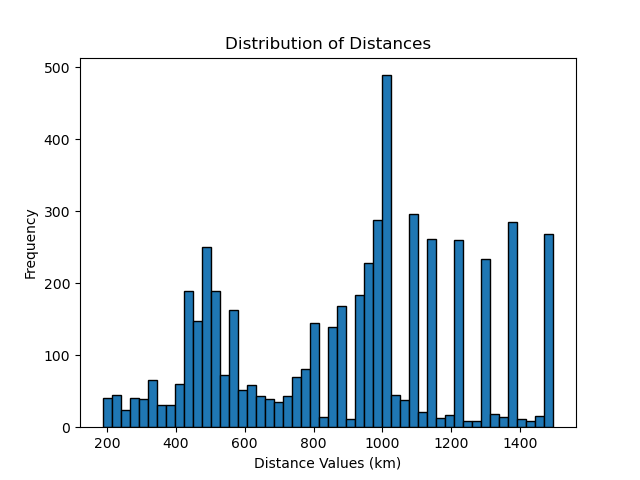

In [58]:
plt.figure()
# Create histogram
plt.hist(d, bins = 50, edgecolor='black')

# Add titles and labels
plt.title('Distribution of Distances')
plt.xlabel('Distance Values (km)')
plt.ylabel('Frequency')
# Show
plt.show()

#### Individual Orbit Checker

In [49]:
day_outliers

['2020-01-01 1',
 '2020-01-01 2',
 '2020-01-01 3',
 '2020-01-01 6',
 '2020-01-01 7',
 '2020-01-01 8',
 '2020-01-02 3',
 '2020-01-02 4',
 '2020-01-02 5',
 '2020-01-02 6',
 '2020-01-02 8',
 '2020-01-02 13',
 '2020-01-07 9',
 '2020-01-07 13',
 '2020-01-07 14',
 '2020-01-11 2',
 '2020-01-11 9',
 '2020-01-11 12',
 '2020-01-11 13',
 '2020-01-15 3',
 '2020-01-15 4',
 '2020-01-15 9',
 '2020-01-15 10',
 '2020-01-15 11',
 '2020-01-15 12',
 '2020-01-15 14',
 '2020-01-19 0',
 '2020-01-19 2',
 '2020-01-19 3',
 '2020-01-19 4',
 '2020-01-19 9',
 '2020-01-19 10',
 '2020-01-19 11',
 '2020-01-19 14',
 '2020-01-23 1',
 '2020-01-23 2',
 '2020-01-23 3',
 '2020-01-23 4',
 '2020-01-23 5',
 '2020-01-23 7',
 '2020-01-23 10',
 '2020-01-23 12',
 '2020-01-23 13',
 '2020-02-06 0',
 '2020-02-06 1',
 '2020-02-06 2',
 '2020-02-06 3',
 '2020-02-06 6',
 '2020-02-06 7',
 '2020-02-06 8',
 '2020-02-06 9',
 '2020-02-06 10',
 '2020-02-06 11',
 '2020-02-06 12',
 '2020-02-06 13',
 '2020-02-06 14',
 '2020-02-08 1',
 '2020-02-0

[811.3609332800002,
 885.1210181236365,
 973.6331199360002,
 1145.4507293364707,
 1298.1774932480002,
 1497.8971075938464]

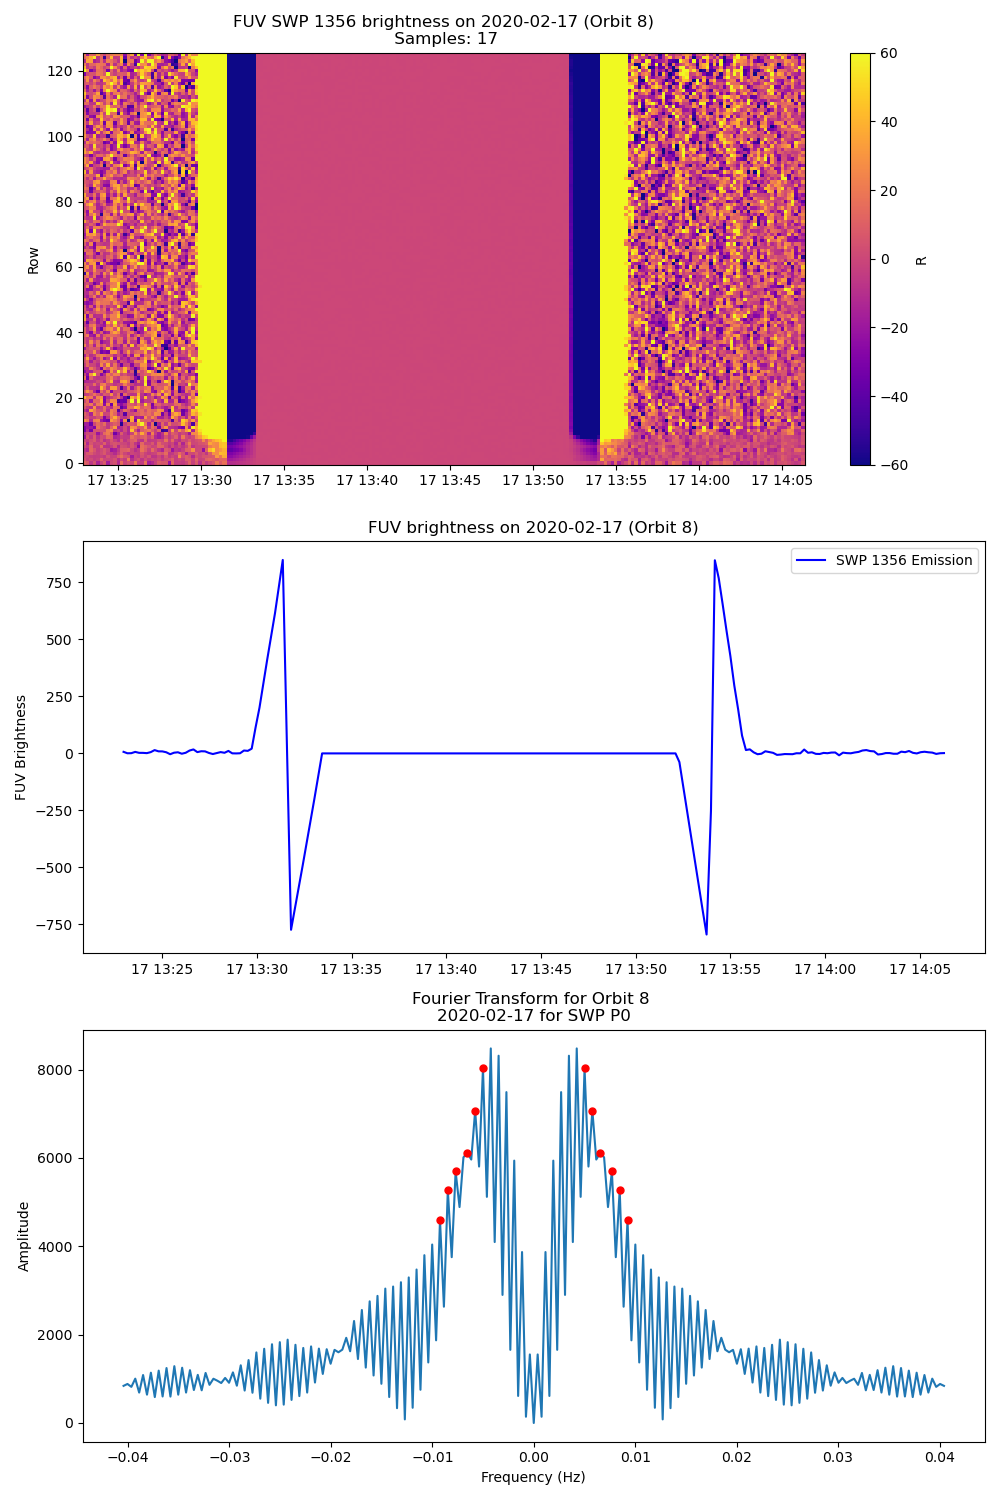

In [50]:
L1f_swp = 'ICON_L1_FUV_SWP_2020-02-17_v05r000.NC'
parts = L1f_swp.split('_')
day = str(parts[4])

swp_p0 = data_opening_w_stripe('P0',L1f_swp)
swp = orbits_finder(swp_p0)[8]
wavelength_plots(swp,day,8,17)

[294.82454545454544,
 318.9904918032787,
 367.14000000000004,
 442.2368181818182,
 474.5956097560976,
 627.6909677419357,
 884.4736363636364,
 1144.6129411764707,
 1496.8015384615387]

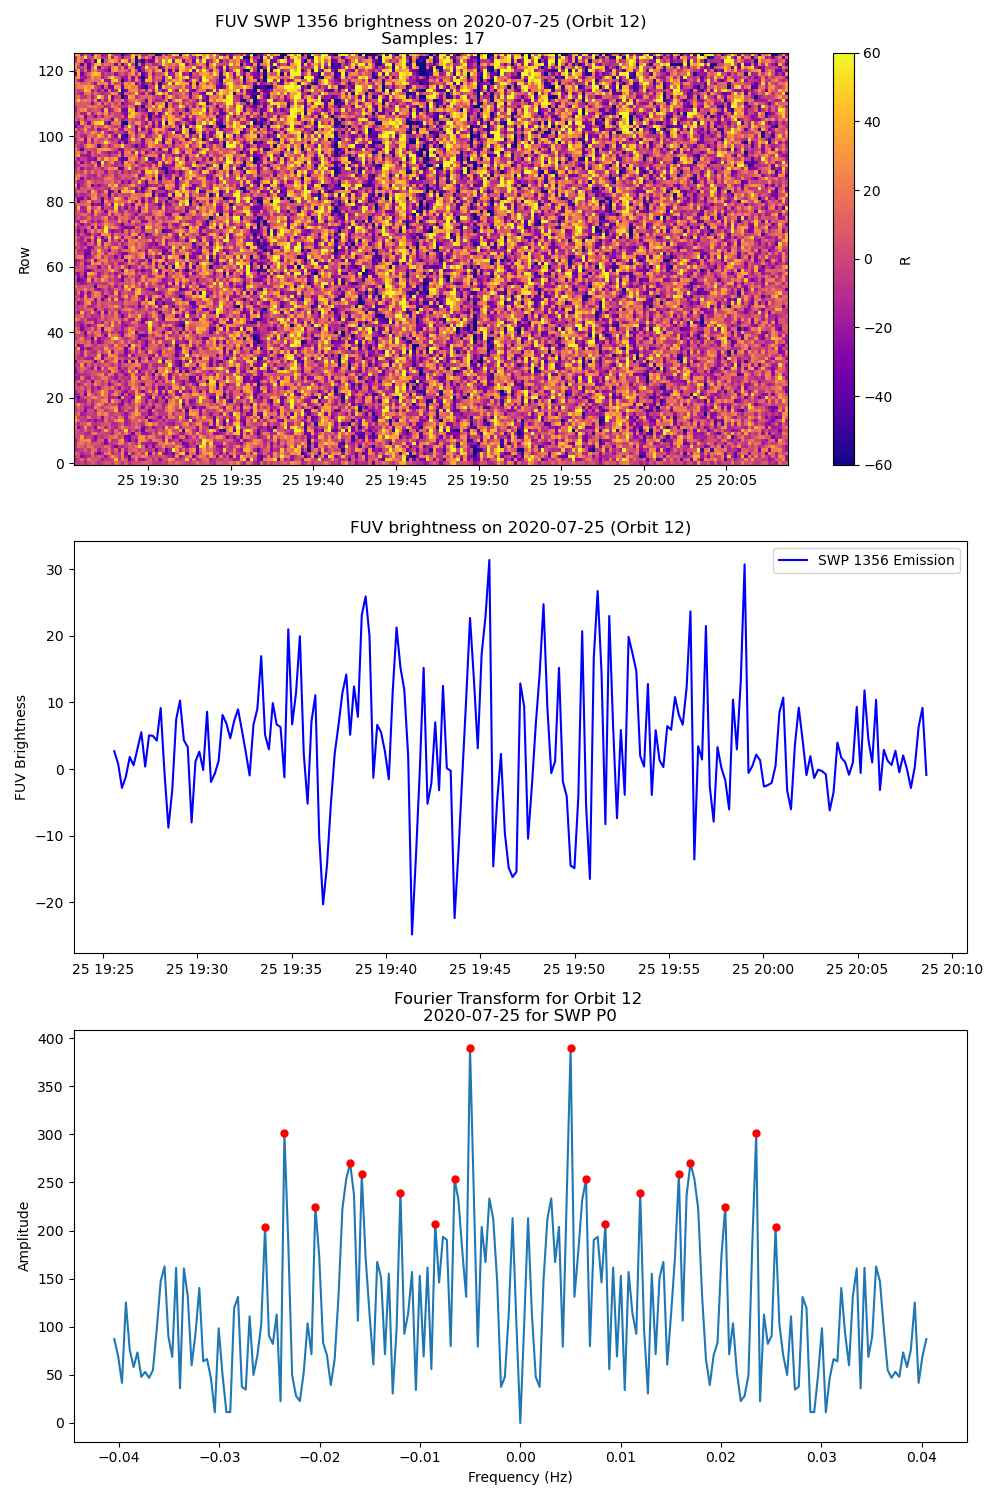

In [51]:
L1f_swp = 'ICON_L1_FUV_SWP_2020-07-25_v05r000.NC'
parts = L1f_swp.split('_')
day = str(parts[4])

swp_p0 = data_opening_w_stripe('P0',L1f_swp)
swp = orbits_finder(swp_p0)[12]
wavelength_plots(swp,day,12,17)

[525.2530434782609, 575.2771428571428, 1006.735]

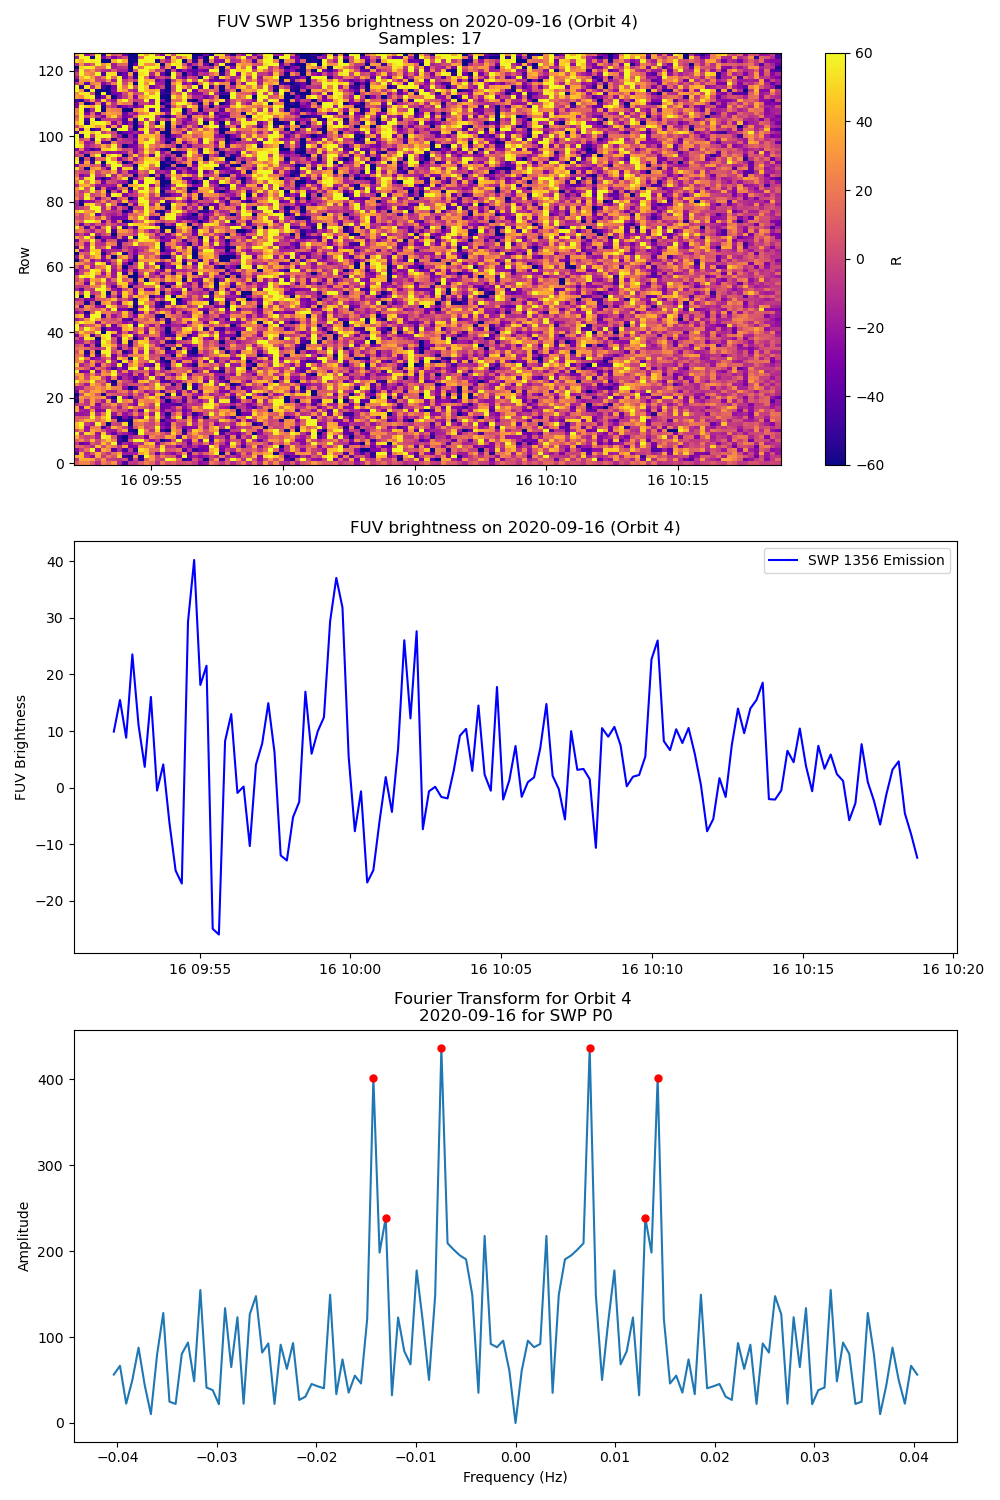

In [52]:
L1f_swp = 'ICON_L1_FUV_SWP_2020-09-16_v05r000.NC'
parts = L1f_swp.split('_')
day = str(parts[4])

swp_p0 = data_opening_w_stripe('P0',L1f_swp)
swp = orbits_finder(swp_p0)[4]
wavelength_plots(swp,day,4,17)

### DOMINANT PEAK FINDER- 17 SAMPLE

In [22]:
# Define the directory path (change this to your directory)
directory_path = "/Users/pkoll/ICON_FUV"

# Use glob to find all CSV files in the directory
file_pattern = os.path.join(directory_path, '*.nc')  
files = glob.glob(file_pattern)

all_dists = []

# Check if we found more than 1 file
if len(files) > 1:
    print(f"Found {len(files)} files. Processing...")

    # Iterate over the files and process each one
    for file_path in files:
        try:
           # print(file_path)
            file_name = os.path.basename(file_path)
           # print(file_name)
            
            swp_p0 = data_opening_w_stripe('P0',file_name)             
            
            # Day Name
            parts = file_name.split('_')
            day = parts[4]

            print("All Data Opened for", day)

            for orbit in range(0,15):
                swp_data = orbits_finder(swp_p0)[orbit]
                result = dominant_wavelength_finder(swp_data,day,orbit,17)
                dist_vals = result[0]

                all_dists.append(dist_vals)
            
            print(f' DONE: Entirely Processed {day}')
        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

else:
    print(f"Found only {len(files)} files. Not enough files to process.")

Found 132 files. Processing...
Error processing /Users/pkoll/ICON_FUV\ICON_L0P_FUV_Ancillary_2020-09-24_v03r002.NC: cannot access local variable 'dsf' where it is not associated with a value
All Data Opened for 2019-11-16
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2019-11-16_v05r001.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-01-01
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-01-01_v05r000.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-01-02
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-01-02_v05r001.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-03-22
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-03-22_v05r000.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-05-10
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-05-10_v05r000.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-01-01
 DONE: Entirely Pr

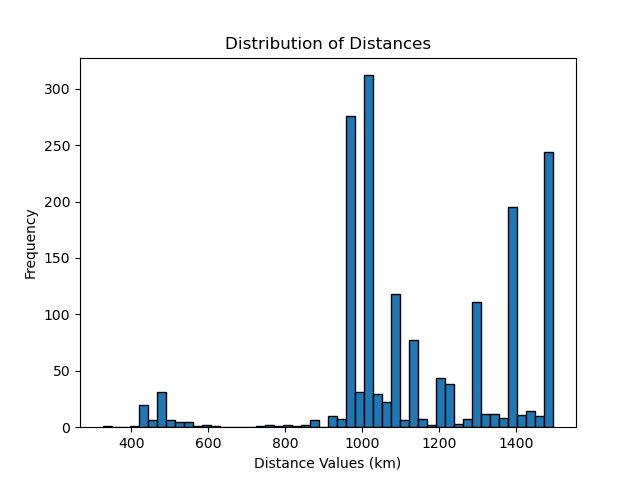

In [23]:
plt.figure()
# Create histogram
plt.hist(all_dists, bins = 50, edgecolor='black')

# Add titles and labels
plt.title('Distribution of Distances')
plt.xlabel('Distance Values (km)')
plt.ylabel('Frequency')
# Show
plt.show()

#### DOMINANT PEAK FINDER - 23 SAMPLE

In [24]:
# Define the directory path (change this to your directory)
directory_path = "/Users/pkoll/ICON_FUV"

# Use glob to find all CSV files in the directory
file_pattern = os.path.join(directory_path, '*.nc')  
files = glob.glob(file_pattern)

all_dists = []

# Check if we found more than 1 file
if len(files) > 1:
    print(f"Found {len(files)} files. Processing...")

    # Iterate over the files and process each one
    for file_path in files:
        try:
           # print(file_path)
            file_name = os.path.basename(file_path)
           # print(file_name)
            
            swp_p0 = data_opening_w_stripe('P0',file_name)             
            
            # Day Name
            parts = file_name.split('_')
            day = parts[4]

            print("All Data Opened for", day)

            for orbit in range(0,15):
                swp_data = orbits_finder(swp_p0)[orbit]
                result = dominant_wavelength_finder(swp_data,day,orbit,23)
                dist_vals = result[0]

                all_dists.append(dist_vals)
            
            print(f' DONE: Entirely Processed {day}')
        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

else:
    print(f"Found only {len(files)} files. Not enough files to process.")

Found 132 files. Processing...
Error processing /Users/pkoll/ICON_FUV\ICON_L0P_FUV_Ancillary_2020-09-24_v03r002.NC: cannot access local variable 'dsf' where it is not associated with a value
All Data Opened for 2019-11-16
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2019-11-16_v05r001.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-01-01
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-01-01_v05r000.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-01-02
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-01-02_v05r001.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-03-22
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-03-22_v05r000.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-05-10
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-05-10_v05r000.NC: 'Dataset' object has no attribute 'I_1356'
All Data Opened for 2020-01-01
 DONE: Entirely Pr

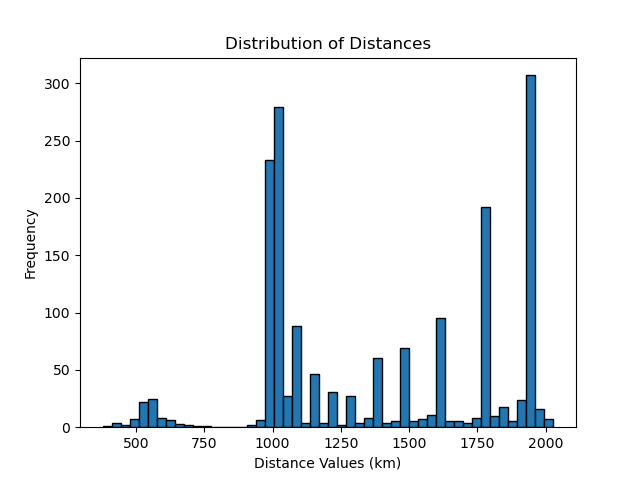

In [25]:
plt.figure()
# Create histogram
plt.hist(all_dists, bins = 50, edgecolor='black')

# Add titles and labels
plt.title('Distribution of Distances')
plt.xlabel('Distance Values (km)')
plt.ylabel('Frequency')
# Show
plt.show()